In [106]:
url = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv'

In [107]:
import wget
import pandas as pd
import itertools
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [108]:
data=wget.download(url)
df=pd.read_csv(data)

In [109]:
df.head(3)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male


In [110]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])

In [111]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

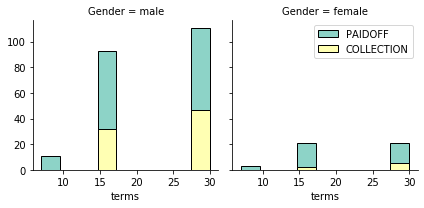

In [112]:
bins = np.linspace(df.terms.min(), df.terms.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set3", col_wrap=2)
g.map(plt.hist, 'terms', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

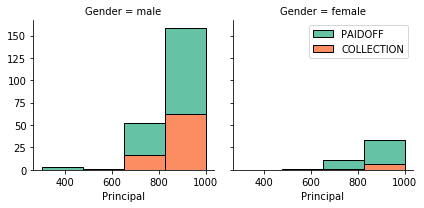

In [113]:

bins = np.linspace(df.Principal.min(), df.Principal.max(), 5)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

From the graph above, Term seems to be an insignificant parameter

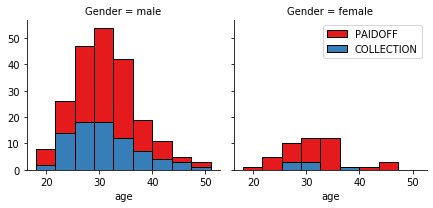

In [114]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=3)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

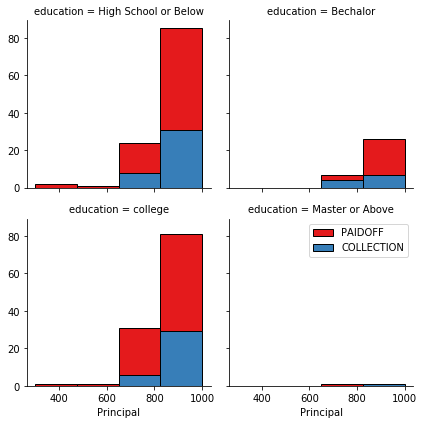

In [115]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 5)
g = sns.FacetGrid(df, col="education", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing: Feature selection/extraction

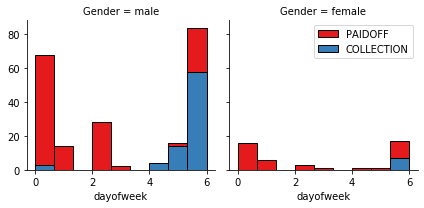

In [116]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [117]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# Convert Categorical features to numerical values

In [118]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay their loans while only 73 % of males pay there loan

Converting male to 0 and female to 1:

In [119]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# One Hot Encoding

In [120]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [121]:
Feature = df[['loan_status', 'Principal', 'terms', 'age', 'education', 'Gender', 'dayofweek', 'weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.drop(['education'], axis = 1,inplace=True)
Feature.columns

Index(['loan_status', 'Principal', 'terms', 'age', 'Gender', 'dayofweek',
       'weekend', 'Bechalor', 'High School or Below', 'college'],
      dtype='object')

# Classification

## K Nearest Neighbour

In [122]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X_KNN, y_KNN, test_size=0.16, random_state=4)

In [123]:
X_KNN = Feature[['Principal', 'age', 'Gender', 'dayofweek', 'Bechalor','High School or Below', 'college']]
y_KNN = Feature['loan_status'].values
X_KNN= preprocessing.StandardScaler().fit(X_KNN).transform(X_KNN)

In [124]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.69642857, 0.625     , 0.76785714, 0.625     , 0.71428571,
       0.66071429, 0.67857143, 0.67857143, 0.71428571])

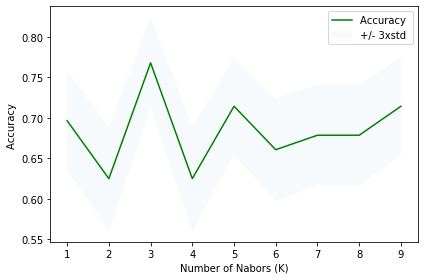

In [125]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.03)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [126]:
print( "The best accuracy was", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was 0.7678571428571429 with k= 3


In [127]:
k = mean_acc.argmax()+1  
bestKnn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

## Decision Tree 

In [128]:
X_DT=Feature.drop('loan_status',axis=1)
y_DT = df['loan_status'].values
X_DT= preprocessing.StandardScaler().fit(X_DT).transform(X_DT)

In [129]:
X_train, X_test, y_train, y_test = train_test_split( X_DT, y_DT, test_size=0.08, random_state=2)

In [130]:
from sklearn.tree import DecisionTreeClassifier

DTmet=list()
for dep in range(1,9):   
    LoanTree = DecisionTreeClassifier(criterion="entropy", max_depth = dep).fit(X_train,y_train)
    LoanPredict=LoanTree.predict(X_test)
    DTmet.append(metrics.accuracy_score(y_test, LoanPredict))

### The most optimal depth for the decision tree would be 5, depth below 5 would lead to underfit and above 5 will lead to overfit along with decreased accuracy

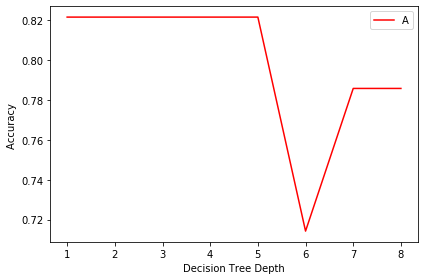

In [131]:
plt.plot(range(1,9),DTmet,'r')
plt.legend('Accuracy ')
plt.ylabel('Accuracy ')
plt.xlabel('Decision Tree Depth')
plt.tight_layout()
plt.show()
LoanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 5).fit(X_train,y_train)

## Support Vector Machine

In [132]:
y_SVM = Feature['loan_status'].values
X_SVM=Feature.drop('loan_status',axis=1)
X_SVM=np.asarray(X_SVM)
X_SVM= preprocessing.StandardScaler().fit(X_SVM).transform(X_SVM)

### Training the SVM model on four separate kernels and selecting the most accurate one

In [133]:
X_train, X_test, y_train, y_test = train_test_split( X_SVM, y_SVM, test_size=0.15, random_state=4)
from sklearn import svm
kernel_=['rbf','sigmoid','linear','poly']
scoredict=dict()
for kern in kernel_:
    loanSVM = svm.SVC(kernel=str(kern),gamma='auto').fit(X_train, y_train) 
    yhatSVM = loanSVM.predict(X_test)
    scoredict[str(kern)]=loanSVM.score(X_test,y_test)
    
print(pd.DataFrame(scoredict,index=['Score']))
kernel_=max(scoredict, key=scoredict.get)
loanSVM = svm.SVC(kernel=str(kernel_),gamma='auto').fit(X_train, y_train)

            rbf   sigmoid    linear      poly
Score  0.788462  0.769231  0.807692  0.788462


# Logistic Regression

In [134]:
X_LR = Feature.drop('loan_status',axis=1)
y_LR = Feature['loan_status'].values
X_LR = preprocessing.StandardScaler().fit(X_LR).transform(X_LR)

In [135]:
X_train, X_test, y_train, y_test = train_test_split( X_LR, y_LR, test_size=0.1, random_state=3)

In [136]:
from sklearn.linear_model import LogisticRegression
solvers=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
LRdict=dict()
for sol in solvers:
    LR = LogisticRegression(C=0.1,solver=str(sol)).fit(X_train,y_train)
    yhatLR = LR.predict(X_test)
    LRdict[sol]=jaccard_similarity_score(yhatLR,y_test)
print(pd.DataFrame(LRdict,index=['Jaccard Similarity Index']))
solver=max(LRdict, key=LRdict.get)
LR = LogisticRegression(C=0.1,solver=str(solver)).fit(X_train,y_train)

                          newton-cg     lbfgs  liblinear       sag      saga
Jaccard Similarity Index   0.714286  0.714286   0.685714  0.714286  0.714286


# Model Evaluation on Test set

In [137]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
algo=dict()

In [138]:
test_url='https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv'
test_data=wget.download(test_url)

In [139]:
test_df=pd.read_csv(test_data)

In [140]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df = pd.concat([test_df,pd.get_dummies(test_df['education'])], axis=1)

# For KNN

In [155]:
yT = test_df['loan_status'].values
XF=test_df[['Principal', 'age', 'Gender', 'dayofweek', 'Bechalor','High School or Below', 'college']]
XF= preprocessing.StandardScaler().fit(XF).transform(XF)

In [156]:
yhatKNN = bestKnn.predict(XF)
print("Test set Accuracy: ", metrics.accuracy_score(yT, yhatKNN),'\n')
print (classification_report(yT, yhatKNN))
algo['KNN']=[jaccard_score(yT, yhatKNN,average='weighted'),f1_score(yT, yhatKNN, average='weighted')]

Test set Accuracy:  0.7037037037037037 

              precision    recall  f1-score   support

  COLLECTION       0.44      0.50      0.47        14
     PAIDOFF       0.82      0.78      0.79        40

    accuracy                           0.70        54
   macro avg       0.63      0.64      0.63        54
weighted avg       0.72      0.70      0.71        54



# For Decision Tree

In [157]:
Feature_Test = test_df[[ 'Principal', 'terms', 'age', 'Gender', 'dayofweek','weekend', 'Bechalor', 'High School or Below', 'college']]
XF=Feature_Test
XF= preprocessing.StandardScaler().fit(XF).transform(XF)
yT = test_df['loan_status'].values

In [158]:
yhatDTree=LoanTree.predict(XF)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(yT,yhatDTree))
print (classification_report(yT, yhatDTree))

algo['Decision Tree']=[jaccard_score(yT, yhatDTree,average='weighted'),f1_score(yT, yhatDTree, average='weighted')]

DecisionTrees's Accuracy:  0.8148148148148148
              precision    recall  f1-score   support

  COLLECTION       1.00      0.29      0.44        14
     PAIDOFF       0.80      1.00      0.89        40

    accuracy                           0.81        54
   macro avg       0.90      0.64      0.67        54
weighted avg       0.85      0.81      0.77        54



# For SVM

In [159]:
XF= test_df[['Principal', 'terms', 'age', 'Gender', 'dayofweek','weekend', 'Bechalor', 'High School or Below', 'college']]
XF= preprocessing.StandardScaler().fit(XF).transform(XF)
yT = test_df['loan_status'].values

In [160]:
yhatSVM = loanSVM.predict(XF)
loanSVM.score(XF,yT)
print (classification_report(yT, yhatSVM))
algo['SVM']=[jaccard_score(yT, yhatSVM,average='weighted'),f1_score(yT, yhatSVM, average='weighted')]

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        14
     PAIDOFF       0.74      1.00      0.85        40

    accuracy                           0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54



In [161]:
import warnings
warnings.filterwarnings('ignore')

# For Logistic Regression

In [162]:
XF = test_df[['Principal', 'terms', 'age', 'Gender', 'dayofweek','weekend', 'Bechalor', 'High School or Below', 'college']]
XF= preprocessing.StandardScaler().fit(XF).transform(XF)

In [163]:
yhatLR = LR.predict(XF)

print("jaccard_similarity_score :",jaccard_similarity_score(yT, yhatLR),"\n")
print (classification_report(yT, yhatLR))
algo['Logistic Regression']=[jaccard_score(yT, yhatLR,average='weighted'),f1_score(yT, yhatLR, average='weighted')]

jaccard_similarity_score : 0.7407407407407407 

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        14
     PAIDOFF       0.74      1.00      0.85        40

    accuracy                           0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54



# REPORT 

In [164]:
pd.DataFrame(algo,index=['Jaccard Similarity Score','F1 Score']).transpose()

,Jaccard Similarity Score,F1 Score
KNN,0.567479,0.709782
Decision Tree,0.666667,0.773663
SVM,0.548697,0.630418
Logistic Regression,0.548697,0.630418


For the given dataset, Decision Tree is the most accurate algorithm to determine whether or not a customer will default on loan payment